In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image
import zipfile

The purpose of this project is to build a GAN (Generative Adversarial Network) to transform photos into Monet-style paintings. GANs consist of two neural networks: a generator that creates images and a discriminator that evaluates their realism. The generator is trained to produce Monet-style images that fool the discriminator, while the discriminator learns to distinguish between real Monet paintings and generated images. Using techniques like cycle consistency and identity preservation, this CycleGAN model ensures that the generated images retain the structure of the original photos while applying the artistic style of Monet. The final output includes thousands of Monet-style images that mimic his artistic characteristics.

First of all, I must load the Monet paintings and photos.

In [2]:
#Load images 
def load_images_from_folder(folder, n=5):
    images = []
    for i, filename in enumerate(os.listdir(folder)):
        if i >= n:  
            break
        img_path = os.path.join(folder, filename)
        image = Image.open(img_path).convert('RGB')
        images.append(image)
    return images

# Function to display a few images from a list
def display_images(images, n=5):
    plt.figure(figsize=(15, 10))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        plt.axis('off') 
    plt.show()

Let's check the paintings and the photos could be loaded properly.

Displaying some Monet images:


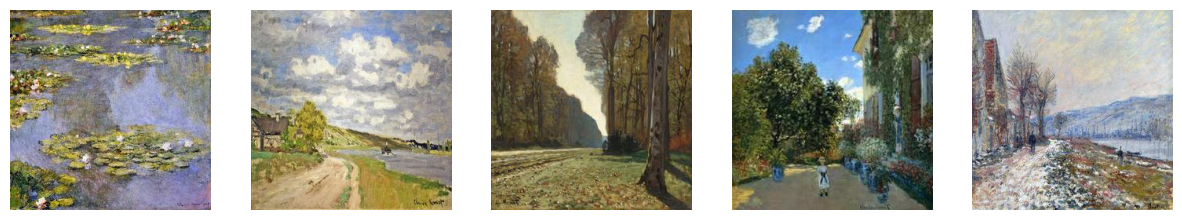

Displaying some photos:


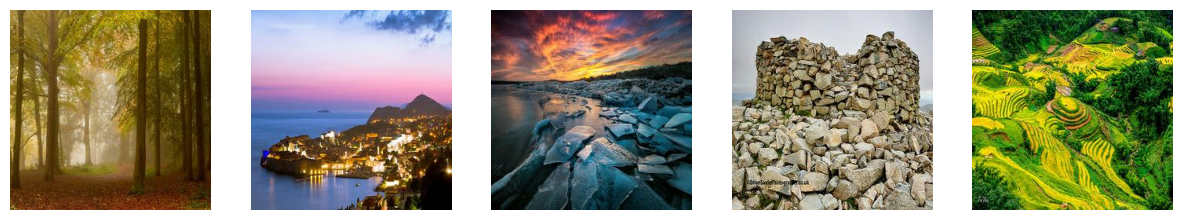

In [3]:
# Load and display some Monet paintings
monet_images_raw = load_images_from_folder('/kaggle/input/gan-getting-started/monet_jpg', n=5)
print("Displaying some Monet images:")
display_images(monet_images_raw, n=5)

# Load and display some photos
photo_images_raw = load_images_from_folder('/kaggle/input/gan-getting-started/photo_jpg', n=5)
print("Displaying some photos:")
display_images(photo_images_raw, n=5)

It looks like the paintings and the photos are properly loaded.

In [4]:
# Dataset class
class SimpleDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

In [5]:
# Data preparation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

monet_data = SimpleDataset(root_dir='/kaggle/input/gan-getting-started/monet_jpg', transform=transform)
monet_loader = DataLoader(monet_data, batch_size=4, shuffle=True)

photo_data = SimpleDataset(root_dir='/kaggle/input/gan-getting-started/photo_jpg/', transform=transform)
photo_loader = DataLoader(photo_data, batch_size=4, shuffle=True)

I just created class, SimpleDatset, to load and preprocess images. Then, transform pipeline resizes all images
to 256 by 256 pixels, applies center crop to ensure consistent dimentions, converts the images to PyTorch tensors and
normalizes pixel to range -1 to 1.

The images are ready to be processed!

Now, it's time to create generator.

The challenge of this project involves building a generative adversarial network (GAN) to generate 7000 to 10000 Monet style images. A GAN consists of a generator, which creates images, and a discriminator, which distinguishes real Monet paintings from the generated ones.

In [6]:
# Generator
class Generator(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            self.downsample(64, 128),
            self.downsample(128, 256),
            *[ResidualBlock(256) for _ in range(6)],
            self.upsample(256, 128),
            self.upsample(128, 64),
            nn.Conv2d(64, output_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh())

    def downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def upsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self, x):
        return self.model(x)

In order to refine the featuers extracted by the generator while preserving the original details of the input
images, ResidualBlock class is needed.

This class helps the generator learn how to apply the Monet style effectively by combining the original features
with newly learned transformations through shortcut connections. This ensures that the generator retains the
structural integrity of the input image while transferring the artistic style.

In [7]:
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.conv_block(x)

Time to build discriminator class.

In [8]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            self.discriminator_block(input_channels, 64, normalization=False),
            self.discriminator_block(64, 128),
            self.discriminator_block(128, 256),
            self.discriminator_block(256, 512),
            nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1)
        )

    def discriminator_block(self, in_channels, out_channels, normalization=True):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
        if normalization:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [9]:
# Initialize models and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G_Monet = Generator(input_channels=3, output_channels=3).to(device)
G_Photo = Generator(input_channels=3, output_channels=3).to(device)
D_Monet = Discriminator(input_channels=3).to(device)
D_Photo = Discriminator(input_channels=3).to(device)

optimizer_G = optim.Adam(list(G_Monet.parameters()) + list(G_Photo.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_Monet = optim.Adam(D_Monet.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_Photo = optim.Adam(D_Photo.parameters(), lr=0.0002, betas=(0.5, 0.999))

Using GPUs instead of CPU makes deep learning tasks significanlty faster.

In [10]:
# Loss functions
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

In [11]:
# Training loop
epochs = 5
for epoch in range(epochs):
    for i, (real_monet, real_photo) in enumerate(zip(monet_loader, photo_loader)):
        real_monet = real_monet.to(device)
        real_photo = real_photo.to(device)

        # Train Generators
        optimizer_G.zero_grad()
        fake_monet = G_Monet(real_photo)
        fake_photo = G_Photo(real_monet)
        loss_GAN = criterion_GAN(D_Monet(fake_monet), torch.ones_like(D_Monet(fake_monet))) + \
                   criterion_GAN(D_Photo(fake_photo), torch.ones_like(D_Photo(fake_photo)))

        # Cycle consistency loss
        recovered_photo = G_Photo(fake_monet)
        recovered_monet = G_Monet(fake_photo)
        loss_cycle = criterion_cycle(recovered_photo, real_photo) + criterion_cycle(recovered_monet, real_monet)

        # Identity loss
        loss_identity = criterion_identity(G_Photo(real_photo), real_photo) + criterion_identity(G_Monet(real_monet), real_monet)

        loss_G = loss_GAN + 10 * loss_cycle + 5 * loss_identity
        loss_G.backward()
        optimizer_G.step()

        # Train Discriminators
        optimizer_D_Monet.zero_grad()
        loss_D_Monet = criterion_GAN(D_Monet(real_monet), torch.ones_like(D_Monet(real_monet))) + \
                       criterion_GAN(D_Monet(fake_monet.detach()), torch.zeros_like(D_Monet(fake_monet.detach())))
        loss_D_Monet.backward()
        optimizer_D_Monet.step()

        optimizer_D_Photo.zero_grad()
        loss_D_Photo = criterion_GAN(D_Photo(real_photo), torch.ones_like(D_Photo(real_photo))) + \
                       criterion_GAN(D_Photo(fake_photo.detach()), torch.zeros_like(D_Photo(fake_photo.detach())))
        loss_D_Photo.backward()
        optimizer_D_Photo.step()

        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i}], Loss G: {loss_G.item():.4f}, D Monet: {loss_D_Monet.item():.4f}, D Photo: {loss_D_Photo.item():.4f}")


Epoch [1/5], Step [0], Loss G: 17.0165, D Monet: 1.3485, D Photo: 1.4282
Epoch [1/5], Step [50], Loss G: 8.6431, D Monet: 0.4589, D Photo: 0.6340
Epoch [2/5], Step [0], Loss G: 8.7589, D Monet: 0.4458, D Photo: 0.4051
Epoch [2/5], Step [50], Loss G: 8.8567, D Monet: 0.4276, D Photo: 0.3681
Epoch [3/5], Step [0], Loss G: 9.3829, D Monet: 0.3804, D Photo: 0.3634
Epoch [3/5], Step [50], Loss G: 9.3551, D Monet: 0.3910, D Photo: 0.3749
Epoch [4/5], Step [0], Loss G: 8.2156, D Monet: 0.3541, D Photo: 0.3694
Epoch [4/5], Step [50], Loss G: 7.1034, D Monet: 0.3836, D Photo: 0.3407
Epoch [5/5], Step [0], Loss G: 6.4265, D Monet: 0.4237, D Photo: 0.3655
Epoch [5/5], Step [50], Loss G: 8.3244, D Monet: 0.3646, D Photo: 0.4174


Training is done. It's time to generate some Monet-style images using the actual photos.

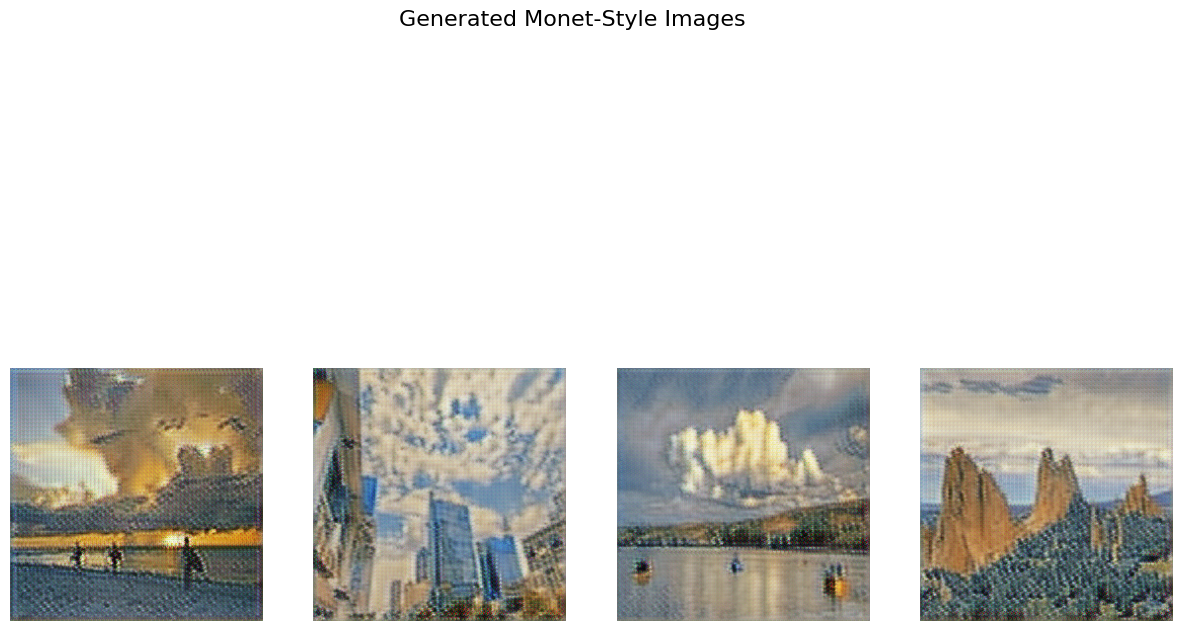

In [12]:
# Set the generator to evaluation mode
G_Monet.eval()

# Get a batch of real photos
real_photo_batch = next(iter(photo_loader)).to(device)

# Generate Monet-style images
with torch.no_grad():
    fake_monet_batch = G_Monet(real_photo_batch)

# Unnormalize images for visualization
fake_monet_batch = (fake_monet_batch * 0.5 + 0.5).clamp(0, 1)

# Display the generated images
plt.figure(figsize=(15, 10))
for i in range(min(4, fake_monet_batch.size(0))):  
    plt.subplot(1, 4, i + 1)
    plt.imshow(fake_monet_batch[i].permute(1, 2, 0).cpu().numpy()) 
    plt.axis('off')
plt.suptitle("Generated Monet-Style Images", fontsize=16)
plt.show()

It looks like the model has been trained and it can generate some Monet-style images.

In [13]:
# Directory to save generated images
output_dir = '/kaggle/working/images'
os.makedirs(output_dir, exist_ok=True)

# Set generator to evaluation mode
G_Monet.eval()

# Total number of images to generate
total_images = 7000
images_saved = 0

# Generate and save images
with torch.no_grad():  
    for i, real_photo in enumerate(photo_loader):
        real_photo = real_photo.to(device)
        fake_monet = G_Monet(real_photo) 

        for j in range(fake_monet.size(0)):
            # Unnormalize and convert to image format
            img = (fake_monet[j].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255  
            img = img.astype(np.uint8) 

            # Ensure image size is 256x256
            img = Image.fromarray(img).resize((256, 256))

            # Save image to writable directory
            img_path = os.path.join(output_dir, f'image_{images_saved + 1}.png')
            img.save(img_path)
            images_saved += 1

            # Stop once we've saved the desired total_images
            if images_saved >= total_images:
                break
        if images_saved >= total_images:
            break

print(f"Generated and saved {images_saved}/{total_images} images in '{output_dir}'")

# Zip all the saved images
zip_filename = '/kaggle/working/images.zip'
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file in os.listdir(output_dir):
        zipf.write(os.path.join(output_dir, file), arcname=file)

print(f"Submission ready: All images zipped into '{zip_filename}'")


Generated and saved 7000/7000 images in '/kaggle/working/images'
Submission ready: All images zipped into '/kaggle/working/images.zip'


Conclusion: This project used a CycleGAN model to transform photos into Monet-style paintings. The generator learned to create realistic Monet-style images, while the discriminator ensured they looked authentic. By using extra loss functions, the model preserved the original photo's structure while applying Monet's artistic style. Increasing the number of training epochs could further improve the results by allowing the model to refine its outputs, though care must be taken to avoid overfitting or wasting resources. This project demonstrates how GANs can effectively be used for artistic transformations.